In [2]:
import numpy as np

In order to properly simulate the final price of our stock under risk neutral assumptions we need to use

$$
S_{T}=S_{0}\exp\left( T\left( r-q-\frac{\sigma^{2}}{2} \right) +\sigma dW_{T}\right)
$$

and

$$
dS_{t}=(r-q)S_{t}dt+\sigma S_{t}dW_{t}
$$

We have a few parameters to keep in mind and those are the same ones our black scholes estimator uses:

- $S_0$ the initial stock price at time $0$
- $K$ the strike price
- $T$ Time to expiration
- $sigma$ volatility
- $r$ the risk free interest rate compounding continuousl
- $q$ the dividends paid out yearly coumpounding continuously


Slight detour: Brownian motion. since we will be dealing with european options, we will not concern ourselves with path dependent pricing, so we only care about the output, since brownian motion has variance $t$ and since it behaves normally we could just sample a bunch of points from $N(0,t)$ and call that our outputs and whilst this is what we'll do in our simulation I think it useful to take the time to simulate paths and check that this is true


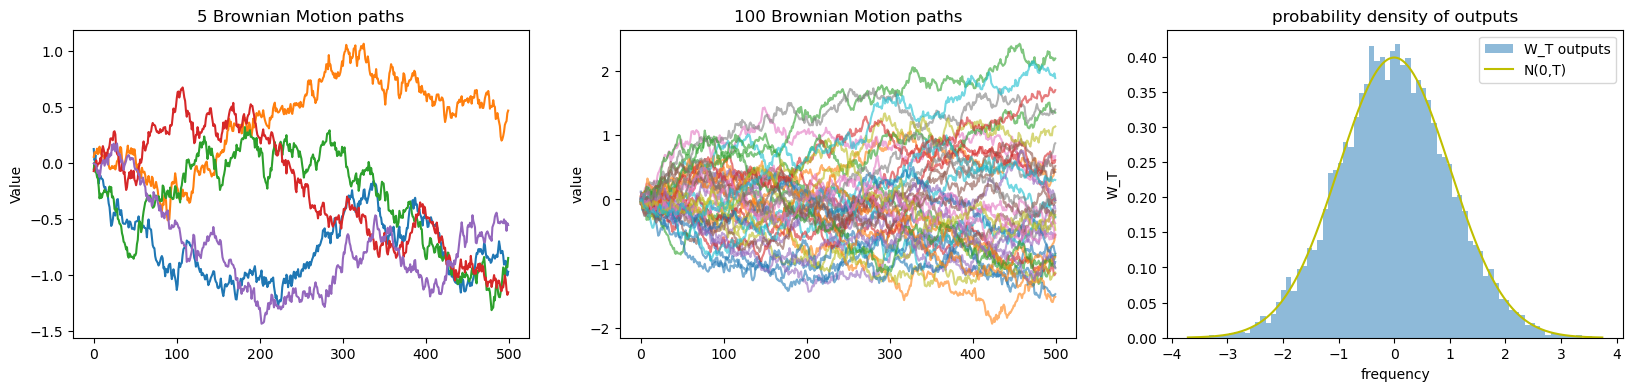

In [3]:
import matplotlib.pyplot as plt

plt.style.use("default")
m_paths = 10000
n_steps = 500
T = 1

dt = T / n_steps

Z = np.random.standard_normal((m_paths, n_steps))
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# axes[0].set_title("random noise")
# axes[0].set_ylabel("value")
# axes[0].plot(Z.T)

dW = np.sqrt(dt) * Z
W = np.cumsum(dW, axis=1)

axes[0].set_title("5 Brownian Motion paths")
axes[0].set_ylabel("Value")

axes[0].plot(W[0:5].T)

axes[1].set_title("100 Brownian Motion paths")
axes[1].set_ylabel("value")
axes[1].plot(W[0:40].T, alpha=0.6)

# Grab the last column aka the output

W_T = W[:, -1]

import scipy.stats as st

x = np.linspace(W_T.min(), W_T.max(), 300)
y = st.norm.pdf(x, loc=0, scale=np.sqrt(T))
axes[2].set_title("probability density of outputs")
axes[2].set_xlabel("frequency")
axes[2].set_ylabel("W_T")
axes[2].hist(W_T, bins=80, density=True, alpha=0.5, label="W_T outputs")
axes[2].plot(x, y, "y", label="N(0,T)")
axes[2].legend()

Indeed, as the number of paths increase the value of the process at time $T$ aka $W_{T}$ approaches a normal distribution with variance $T$, therefore we can simply sample from $N(0,T)$ and compute average discounted payoff from there.


In [4]:
def price_option(
    S0: float,
    K: float,
    T: float,
    sigma: float,
    r: float,
    q: float,
    m_paths: int = 100000,
    n_steps: int = 1000,
):
    dt = T / n_steps
    dW_T = np.sqrt(T) * np.random.standard_normal(m_paths)

    S_T = S0 * np.exp(T * (r - q - 0.5 * (sigma**2)) + sigma * dW_T)

    disc = np.exp(-r * T)  # Discount back by the risk free rate
    return disc * np.maximum(S_T - K, 0).mean()


paths, n_steps = 100, 100

In [5]:
# tests and fiddling
m_paths = 100000
K = 100
S0 = 100
r = 0.05
q = 0.00
sigma = 0.2
T = 1

dW_T = np.sqrt(T) * np.random.standard_normal(m_paths)

S_T = S0 * np.exp(T * (r - q - 0.5 * (sigma**2)) + sigma * dW_T)
disc = np.exp(-r * T)
test_pay = disc * np.maximum(S_T - K, 0).mean()
print(test_pay)
monte_pay = price_option(S0, K, T, sigma, r, q, m_paths)

print(monte_pay)

10.404675799383053
10.538577887984326


Important to calculate payoffs THEN take the mean since we're taking $E[\text{payoff}]$. Here we were able to simply sample once per path since we're assuming european options but if we were using any other type of option we would have to simulate the entire path since pricing shifts depending on path behaviour. All that's left is implementing the black scholes reference and compare

Once again we will use calls

$$
C(S,t)=Se^{(-q(T-t))}\Phi(d_{1})-Ke^{-r(T-t)}\Phi(d_{2})
$$

With

$$
d_{1}=\frac{\ln\left( \frac{S}{K} \right)+\left( r-q+\frac{1}{2}\sigma^{2} \right)(T-t)}{\sigma \sqrt{ T-t }}
$$

$$
d_{2}=d_{1}-\sigma \sqrt{ T-t }
$$

Where each variable means the same thing as before


In [6]:
from scipy.stats import norm


def price_option_black(
    S0: float,
    K: float,
    T: float,
    sigma: float,
    r: float,
    q: float,
    t: float = 0.0,
):
    d1 = (np.log(S0 / K) + (r - q + (0.5 * (sigma**2))) * (T - t)) / (
        sigma * np.sqrt(T - t)
    )
    d2 = d1 - (sigma * np.sqrt((T - t)))

    C = S0 * np.exp((-q * (T - t))) * norm.cdf(d1) - K * np.exp(
        -r * (T - t)
    ) * norm.cdf(d2)
    return C

In [7]:
m_paths = 1000
K = 100
S0 = 100
r = 0.05
q = 0.00
sigma = 0.2
T = 10

monte_pay = price_option(S0, K, T, sigma, r, q, m_paths)
print(monte_pay)

scholes_pay = price_option_black(S0, K, T, sigma, r, q)
print(scholes_pay)

43.7063801772749
45.19297367898936


Now that we've established the monte carlo estimate seems to be converging to the black scholes price, we can plot them against each other


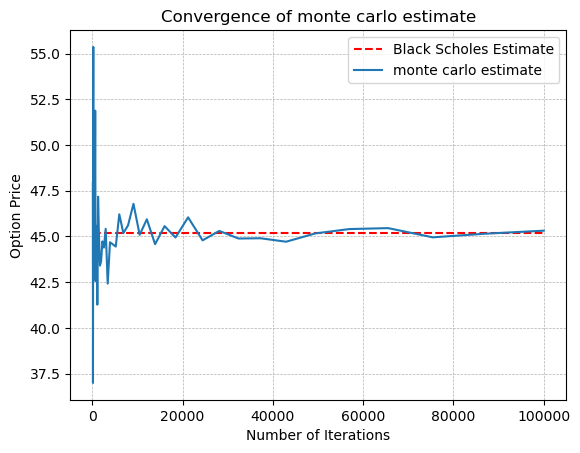

In [32]:
# fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig, axes = plt.subplots()

# m_paths = 100
K = 100
S0 = 100
r = 0.05
q = 0.00
sigma = 0.2
T = 10

n = np.logspace(2, 5, num=50, dtype=int)  # logspace for proper convergence shown
estimates = [price_option(S0, K, T, sigma, r, q, m_paths) for m_paths in n]

bs_estimate = price_option_black(S0, K, T, sigma, r, q)
bs_line = np.full_like(estimates, bs_estimate)
axes.set_ylabel("Option Price")
axes.set_xlabel("Number of Iterations")
axes.set_title("Convergence of monte carlo estimate")
axes.plot(n, bs_line, "r--", label="Black Scholes Estimate")
axes.plot(n, estimates, label="monte carlo estimate")
plt.grid(True, which="both", ls="--", lw=0.5)
axes.legend()